_Carry overs from previous notebook_
    
## Issues

1. Annotated data having issues:
  - (Fixed by sorting chars) different annotators possibly having different order in pairs
  - (Fixed by dropping NR chars / affinity) NR still present with some comments
2. Book sources having issues:
  - different editions of same book might be available with different level of changes (starting with additions / deletions ending with non-rendering font using Æ and others)
  - licensing need to be removed as it introduces extra noise
3. book-nlp output having issues:
  - (Fixed by quote attr) as is, it causes issues when loaded via pandas as there're ocasionally a label for token that is too long or some other issues
  - might result in same character being represented as multiple
4. current algorithm having issues:
  - no way to limit characters to only 'important once', so we can do some sort of validation but either external part should be responsible for selecting the main characters (and it's not yet fact those would be present in annotated relations) or current system updated to account for that
  - sentiment of sentences mentioning two characters isn't the best way, some papers mention other ways of doing this

## Next steps

1. There are still long way to go with this amount of data and this baseline: tuning sentiment, removing stopwords, fixing all of the issues.
2. I have another dataset that need some transforming to be compatible with current one
3. Trying other baselines.

In [171]:
import os
import re

import pandas as pd
import numpy as np
import scipy
import collections as col

from sklearn import metrics
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from nltk.stem.snowball import SnowballStemmer

from tqdm import tqdm

import books_utils as bu
import baseline



In [2]:
stemmer = SnowballStemmer("english")

### Reading in annotations / books

In [3]:
annotations = pd.read_csv('../data/character_relation_annotations.txt.gz', sep='\t')
# dropping values that have gibberish affinity - might transform this later based on category
annotations = annotations[(annotations['affinity'] != 'NR') & (annotations['character_1'] != 'NR') & (annotations['character_2'] != 'NR')].copy()
annotations['book_name'] = (annotations['title'] + ' ' + annotations['author']).str.replace("\s", "_")
print(annotations.shape)
# making sure no NR in character_1/character_2/affinity
annotations.describe()

(2137, 11)


,annotator,change,title,author,character_1,character_2,affinity,coarse_category,fine_category,detail,book_name
count,2137,2137,2137,2137,2137,2137,2137,2137,2137,2137,2137
unique,14,3,109,49,1005,825,3,4,30,528,109
top,annotator_1,no,The Return of the Native,William Shakespeare,Joseph K.,Timon,positive,social,friend,NR,Dracula_Bram_Stoker
freq,760,1712,20,613,15,17,1120,886,342,1591,20


In [4]:
# annotations[annotations['title'] == 'Oliver Twist']

In [5]:
# working around multiple annotators giving different marks - transforming into
# real value based on mapping and averaging it
def avg(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)
affinity_mapping = {
    'positive': 1,
    'neutral': 0.5,
    'negative': 0
}
annotations['num_affinity'] = annotations['affinity'].map(lambda aff: affinity_mapping[aff])
all_df = pd.DataFrame(columns=['book_name', 'char_1', 'char_2', 'affinity'])
by_book_annotations = col.defaultdict(col.defaultdict)
def add_books_annotations(row):
    book_name = row['book_name']
    char_1, char_2 = sorted([row['character_1'], row['character_2']])
    affinity = row['num_affinity']
    by_book_annotations[book_name][char_1 + ':' + char_2] = (by_book_annotations[book_name][char_1 + ':' + char_2] if (char_1 + ':' + char_2) in by_book_annotations[book_name] else []) + [affinity]

annotations.apply(add_books_annotations, axis=1)

for book in by_book_annotations:
    for pair in by_book_annotations[book]:
        [char_1, char_2] = pair.split(':')
        all_df = all_df.append([{
            'book_name': book, 'char_1': char_1, 'char_2': char_2, 'affinity': avg(by_book_annotations[book][pair])
        }])
# voila, afinnity as single column dataframe with real values and all_x having book_name, char_1 and char_2 names
all_y = all_df['affinity'].copy()
all_X = all_df.drop('affinity', axis=1)

In [6]:
# making sure all raw txt files are present for books
titles = annotations['title'].unique()
authors = [annotations[annotations['title'] == title]['author'][0:1].ravel()[0] for title in titles]
existing_files = []
names = []
for pair in zip(titles, authors):
    title, author = pair
    name = re.sub("\s", "_", '{} {}'.format(title, author))
    names.append(name)
    file = '../data/books/{}.txt'.format(name)
    existing_files.append(os.path.isfile(file))
len(titles), len(existing_files), all(existing_files)

(109, 109, True)

In [7]:
books = [bu.Book(name, book_NLP_folder="../data/bookNLP_output", source_folder="../data/books") for name in names]

In [8]:
for book in books:
    if len(book.tokens) < 100:
        print(book.name, len(book.tokens), book.tokens.shape)
# seems that most tokens are non-empty, yet issue with parsing the bookNLP token output into dataframes
# underneath we are skipping those lines

In [32]:
def score_to_label(val):
    if val <= 0.33:
        return 'negative'
    if val <= 0.66:
        return 'neutral'
    return 'positive'

### Reproducing baseline results

In [ ]:
base_predictor = baseline.create_for(books, all_X)

In [ ]:
y_predicted = baseline.predict(base_predictor, all_X)
y_predicted.clip(0, 1, inplace=True)

In [ ]:
metrics.mean_squared_error(y_predicted, all_y)

In [ ]:
print(metrics.classification_report(all_y.map(score_to_label), y_predicted.map(score_to_label)))

In [ ]:
# one more baseline, just to check - major class
y_all_positive = np.ones_like(y_predicted)
print(metrics.mean_squared_error(y_all_positive, all_y))
print(metrics.classification_report(all_y.map(score_to_label), [score_to_label(val) for val in y_all_positive]))
# well, at least our baseline does something more useful

In [ ]:
# Books issues with chars
# WARNING: Mrs. John Dashwood might have multiple aliases: ['Mrs. Dashwood', 'John Dashwood']
# WARNING: Hector son of Priam might have multiple aliases: ['Hector', 'Priam']
# WARNING: Mrs. Joe Gargery might have multiple aliases: ['Joe Gargery', 'Mrs. Joe']
# WARNING: Mrs. Ned Hale might have multiple aliases: ['Mrs. Ned Hale', 'Ned Hale']
# WARNING: Elizabeth-Jane Newson might have multiple aliases: ['Elizabeth-Jane Newson', 'Newson']

In [ ]:
bad_chars = set(["Mrs. John Dashwood",
"Hector son of Priam",
"Mrs. Joe Gargery",
"Mrs. Joe Gargery",
"Mrs. Ned Hale",
"Elizabeth-Jane Newson"])
for (i,book) in enumerate(books):
    for char in book.characters.meaningful:
        if bu.longest_name(char) in bad_chars:
            print(i, book.name, char['id'], bu.longest_name(char))

Even though I identified these chars, I'm not sure what to do with all of this:

1. Mrs. John Dashwood as identificator for wife of Mr. John Dashwood
2. son of Priam mentioning Priam in no way refers to Priam himself
3. Mrs. Joe Gargery as identificator for wife of Mr. Joe Gargery
4. Not even sure about this one, but I think once again this is identificator for wife of Mr. Ned Hale\
5. Newson is used as reference to father of Elizabeth-Jane Newson

so I'm considering adding following rules to bu.book_name_to_annotated_name()

```
Mrs. + Name != Name
X son of Y != Y
Firstname Lastname != Lastname
```

although first one could have another way of working out if we would have gender annotation for characters in dataset (given bookNLP infers gender), yet there are issues with bookNLP getting confused on its own with Mrs. John Dashwood (considering John Dashwood being same character and not Mr. John Dashwood who is character on his own)

🤔 might be an issue for the future

### Further work: affinity prediction

In [9]:
# one thing that was suspicious - for first book there were multiple characters that were mapping to same name
# in annotations, so let's see how many of those are there

for i, book in enumerate(books):
    chars = col.defaultdict(list)
    book_name = book.name
    subset = all_X[all_X['book_name'] == book_name]
    present_chars = pd.concat([subset['char_1'], subset['char_2']]).unique()
    for char in book.characters.meaningful:
        name = bu.book_name_to_annotated_name(book_name, char, present_chars, False)
        if name:
            chars[name].append(char)
    #         print(name, "|", bu.longest_name(char))
    for key in chars:
        if len(chars[key]) > 1:
            print(i, book_name, key, [bu.longest_name(char) for char in chars[key]])

0 Don_Quixote_Miguel_de_Cervantes Don Quixote ['Don Quixotes', 'Senor Don Quixote', 'lord Don Quixote']
0 Don_Quixote_Miguel_de_Cervantes The Duke and Duchess ['Duke of Sesa', 'Duke Ricardo']
0 Don_Quixote_Miguel_de_Cervantes Sancho Panza ['Sancho Panzas', 'Senor Don Sancho Panza']
1 Little_Women_Louisa_May_Alcott Frederick Bhaer ['Mother Bhaer', 'Fred Vaughn']
1 Little_Women_Louisa_May_Alcott Josephine March ['Miss Jo', 'Josephine']
1 Little_Women_Louisa_May_Alcott Mr. Brooke ['Mrs. John Brooke', 'Mr. Brooke']
1 Little_Women_Louisa_May_Alcott Sallie Gardiner ['Miss Sallie', 'Sallie Gardiner']
2 Antony_and_Cleopatra_William_Shakespeare Octavius Caesar ['Octavius Caesar', 'Julius Caesar']
2 Antony_and_Cleopatra_William_Shakespeare Antony ['MARK ANTONY', 'Antony Shall', 'An Antony']
3 Sense_and_Sensibility_Jane_Austen John Dashwood ['Mrs. John Dashwood', 'Mr. John Dashwood']
3 Sense_and_Sensibility_Jane_Austen Sir John Middleton ['John Middleton', 'Lady Middleton']
4 Henry_VIII_William_S

74 Northanger_Abbey_Jane_Austen Henry Tilney ['Mr. Henry Tilney', 'Miss Tilney']
75 Julius_Caesar_William_Shakespeare Cassius ['Caie Cassi', 'Cass']
75 Julius_Caesar_William_Shakespeare Decius ['Deci', 'Decius Brutus']
75 Julius_Caesar_William_Shakespeare Octavius ['Octavi', 'OCTAVIUS']
77 The_Taming_of_the_Shrew_William_Shakespeare Baptista ['Signior Baptista', 'BAPTISTA MINOLA']
77 The_Taming_of_the_Shrew_William_Shakespeare Gremio and Hortensio ['Signior Hortensio', 'Signior Gremio']
80 Mansfield_Park_Jane_Austen Mary Crawford ['Miss Crawford', 'Mary Crawford', 'Mrs. Crawford']
80 Mansfield_Park_Jane_Austen Maria Bertram ['Maria Bertram', 'Miss Maria']
82 Major_Barbara_George_Bernard_Shaw Lady Britomart Undershaft ['Lady Brit', 'Lady Britomart']
84 Main_Street_Sinclair_Lewis Vida Sherwin ['Vida Sherwins', 'Miss Vida Sherwin']
84 Main_Street_Sinclair_Lewis Raymond Wutherspoon ['Ray', 'Raymie Wutherspoon', 'Raymond Wutherspoon']
84 Main_Street_Sinclair_Lewis Maud Dyer ['Mrs. Dave Dyer

ok, seems that we need to 'merge' chars. First, I would try doing that according to some rules:
- Name == Senor Name == lord Name
- Name === Senor Don Name
- Miss Firstname ~~ Miss Firstname Lastname (but not Mrs)
- Mrs. Firstname Lastname ~~ Mrs. Lastname
- some name alternatives might be used Richard -> Dick, William -> Bob, etc
- some initials can be used instead of firstname
- might want to clean `--` in some names and merge with some prefix
- nicknames used in parenthesis might exactly match with name or might be used instead of first name

Basically, might try to rely on gender annotated to char and ability to deduct gender of name based on prefixes used in name + some processing for nicknames

In [10]:
# yet another issue with annotated data - there are entries X and Y
all_df[(all_df['char_1'].str.contains(' and ')) | (all_df['char_2'].str.contains(' and '))]
# further work - need to split it into multiple entries, issue here is what to do with annotation to 'pair' + there
# won't be relations between chars in pair 🤔 - assuming X to Y & Z has same relation as X to Y and X to Z

,book_name,char_1,char_2,affinity
0,Don_Quixote_Miguel_de_Cervantes,Don Quixote,The Duke and Duchess,0.25
0,Don_Quixote_Miguel_de_Cervantes,Sancho Panza,The Duke and Duchess,0.25
0,Don_Quixote_Miguel_de_Cervantes,Altisidora,The Duke and Duchess,0.75
0,Richard_II_William_Shakespeare,Henry Bolingbroke Duke of Herford,Henry Percy Earl of Northumberland; Lord Ross;...,1.00
0,Henry_IV_Part_2_William_Shakespeare,Duke of Gloucester; and Thomas,King Henry IV,1.00
0,Henry_IV_Part_2_William_Shakespeare,Mowbray and Hastings,Prince Hal (later King Henry V),0.00
0,Ulysses_James_Joyce,Josie (née Powell) and Denis Breen,Leopold Bloom,0.50
0,Pride_and_Prejudice_Jane_Austen,Elizabeth Bennet,Mr. and Mrs. Gardiner,1.00
0,The_House_of_Mirth_Edith_Wharton,Jack Stepney and Gwen Stepney,Lily Bart,1.00
0,Hamlet_William_Shakespeare,Hamlet,Rosencrantz and Guildenstern,0.00


In [11]:
# https://git.io/vpzth
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []

    def splitListToRows(row, separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)

    df.apply(splitListToRows, axis=1, args = (separator, ))
    new_df = pd.DataFrame(row_accumulator)
    return new_df

new_df = splitDataFrameList(all_df, 'char_1', ' and ')
new_df = splitDataFrameList(new_df, 'char_2', ' and ')

all_y = new_df['affinity'].copy()
all_X = new_df.drop('affinity', axis=1)
# Removed cells retraining baseline as we got 36 extra rows in X / Y and it didn't affect any metrics,
# apart from droping by 0.01 recall for one class

In [12]:
# First point: find 'main' characters close to those in annotations
# might putting this into book_utils.py
def get_rel_stats(book):
    meaningful_rels = {}
    rels = col.defaultdict(col.Counter)
    for p in book.paragraphs:
        chars = set(p[p['characterId'] > 0 ]['characterId'].unique())
        for char in chars:
            if len(chars) > 1:
                other_chars = chars - set([char])
                rels[char].update(list(other_chars))
    sums = {}
    counts = {}
    for char in rels:
        sums[char] = sum(rels[char].values())
        counts[char] = len(rels[char].values())
    return rels, sums, counts
def get_meaningful_chars(book):
    rels, sums, counts = get_rel_stats(book)
    possible_chars = book.characters.meaningful
    
    filtered = [char for char in possible_chars if char['id'] in sums and sums[char['id']] > 3]
    return filtered

def evaluate(book, chars, present_chars):
    total = 0
    tp = 0
    found_chars = set([])
    for char in chars:
        name = bu.book_name_to_annotated_name(book.name, char, present_chars, False)
        if name:
            found_chars.update([name])
#     print(found_chars)
#     print(set(present_chars) - found_chars)        
    return len(found_chars) == len(present_chars), len(present_chars) - len(found_chars), len(chars) - len(present_chars)

In [13]:
got_all_count = 0
total_unmatched = 0
total_extra = 0
for book in tqdm(books):
    # rels, sums, counts = get_rel_stats(book)
    meaningful = get_meaningful_chars(book)
    target_X = all_X[all_X['book_name'] == book.name]
    present_chars = pd.concat([target_X['char_1'], target_X['char_2']]).unique()
    got_all, unmatched, extra_matched = evaluate(book, meaningful, present_chars)
    if got_all:
        got_all_count += 1
        print(f'got_all for {book.name}')
    total_unmatched += unmatched
    total_extra += extra_matched
print(f'got_all {got_all_count}, total_unmatched {total_unmatched}, total_extra {total_extra}')

  2%|▏         | 2/109 [00:12<12:04,  6.77s/it]

got_all for Little_Women_Louisa_May_Alcott


  4%|▎         | 4/109 [00:15<07:20,  4.20s/it]

  9%|▉         | 10/109 [00:39<06:52,  4.17s/it]

got_all for Typee_Herman_Melville


 12%|█▏        | 13/109 [00:54<08:00,  5.01s/it]

got_all for Emma_Jane_Austen


 15%|█▍        | 16/109 [01:04<05:52,  3.79s/it]

got_all for The_Adventures_of_Tom_Sawyer_Mark_Twain


 29%|██▉       | 32/109 [01:56<06:26,  5.02s/it]

got_all for Ulysses_James_Joyce


 30%|███       | 33/109 [01:58<05:04,  4.01s/it]

 35%|███▍      | 38/109 [02:04<02:33,  2.17s/it]

got_all for O_Pioneers!_Willa_Cather


 39%|███▉      | 43/109 [03:00<14:21, 13.05s/it]

got_all for War_and_Peace_Leo_Tolstoy


 40%|████      | 44/109 [03:12<13:59, 12.92s/it]

got_all for Middlemarch_George_Eliot


 41%|████▏     | 45/109 [03:16<10:46, 10.11s/it]

got_all for Pride_and_Prejudice_Jane_Austen


 45%|████▍     | 49/109 [03:22<03:45,  3.75s/it]

got_all for Anne_of_Green_Gables_L._M._Montgomery


 47%|████▋     | 51/109 [03:27<03:08,  3.26s/it]

got_all for Babbitt_Sinclair_Lewis


 49%|████▊     | 53/109 [03:32<02:41,  2.89s/it]

 51%|█████▏    | 56/109 [03:41<03:03,  3.47s/it]

 56%|█████▌    | 61/109 [03:50<01:50,  2.30s/it]

got_all for Dracula_Bram_Stoker


 57%|█████▋    | 62/109 [03:53<01:54,  2.43s/it]

got_all for The_House_of_Mirth_Edith_Wharton


 59%|█████▊    | 64/109 [03:59<02:17,  3.06s/it]

got_all for Howards_End_E._M._Forster


 64%|██████▍   | 70/109 [04:09<00:56,  1.46s/it]

got_all for Far_from_the_Madding_Crowd_Thomas_Hardy


 65%|██████▌   | 71/109 [04:10<00:49,  1.31s/it]

 72%|███████▏  | 78/109 [04:29<01:04,  2.08s/it]

got_all for The_Taming_of_the_Shrew_William_Shakespeare


 74%|███████▍  | 81/109 [04:35<01:00,  2.15s/it]

got_all for Mansfield_Park_Jane_Austen


 77%|███████▋  | 84/109 [04:45<01:22,  3.29s/it]

got_all for The_Portrait_of_a_Lady_Henry_James


 78%|███████▊  | 85/109 [04:51<01:41,  4.22s/it]

got_all for Main_Street_Sinclair_Lewis


 94%|█████████▎| 102/109 [05:21<00:10,  1.46s/it]

got_all for Pygmalion_George_Bernard_Shaw


 94%|█████████▍| 103/109 [05:25<00:13,  2.18s/it]

got_all for The_Mayor_of_Casterbridge_Thomas_Hardy


100%|██████████| 109/109 [05:39<00:00,  2.99s/it]

got_all 21, total_unmatched 357, total_extra 4211


In [14]:
# with sum threshold 10 - got_all 8, total_unmatched 533, total_extra 1145
# with sum threshold 5 - got_all 12, total_unmatched 430, total_extra 2220
# 🌟 with sum threshold 3 - got_all 16, total_unmatched 394, total_extra 2940
# with sum threshold 1 - got_all 19, total_unmatched 353, total_extra 3950
# with sum threshold 0 - got_all 19, total_unmatched 339, total_extra 4501
# with counts threshold 2 - got_all 15, total_unmatched 399, total_extra 3172

Okay, after putting some time into trying to identify subset of characters that are important to make this slightly faster to compute and more interesting in terms of end-2-end running and not just classification by making sure we are capturing all the important characters and as little as possible unimportant ones I have 2 things to share:
- some simple metric isn't good enough and this might need another model 🤦 
- no need to care about 'extra' characters, but should aim at do finding all the chars that were labelled
(partially this is caused by 'unmerged'chars)

In [15]:
all_y.shape

(1486,)

In [16]:
categories = annotations[['book_name', 'character_1', 'character_2', 'coarse_category']].copy()
new_categories = splitDataFrameList(categories, 'character_1', ' and ')
new_categories = splitDataFrameList(new_categories, 'character_2', ' and ')

def lookup_category(row):
    matching_categories = new_categories[
        (new_categories['book_name'] == row['book_name']) &
        ((new_categories['character_1'] == row['char_1']) & (new_categories['character_2'] == row['char_2']) |
        (new_categories['character_2'] == row['char_1']) & (new_categories['character_1'] == row['char_2']))
        & (new_categories['coarse_category'] != 'NR')
    ]['coarse_category'].unique()
    # Okay, super weird thing, but going with the whim here and might redo later
    # professional > familial > social
    if 'professional' in matching_categories:
        return 'professional'
    if 'familial' in matching_categories:
        return 'familial'
    if 'social' in matching_categories:
        return 'social'

new_df['category'] = new_df.apply(lookup_category, axis=1)

In [17]:
categories['coarse_category'].value_counts()

social          886
familial        823
professional    421
NR                7
Name: coarse_category, dtype: int64

In [18]:
new_categories['coarse_category'].value_counts()

social          897
familial        830
professional    427
NR                7
Name: coarse_category, dtype: int64

In [19]:
# given we had overlaps, there would be fewer entries
new_df['category'].value_counts()

social          589
familial        559
professional    335
Name: category, dtype: int64

In [20]:
all_y = new_df[['affinity', 'category']].copy()
all_X = new_df.drop(['affinity', 'category'], axis=1)

In [21]:
book_mapping = {}
book_names = all_X['book_name'].unique()
for name in book_names:
    found = False
    for book in books:
        if found:
            break
        if book.name == name:
            book_mapping[name] = book
            found = True
"DONE"

'DONE'

In [22]:
all_y['category'].describe()

count       1483
unique         3
top       social
freq         589
Name: category, dtype: object

In [210]:
X_train_aff, X_test_aff, y_train_aff, y_test_aff = train_test_split(all_X, all_y['affinity'], test_size=0.33, random_state=42)

### BOW + LogReg

In [94]:
# This was supposed to be a separate incapsulated fn, but I forgot about it 😅
X = all_X # selecting subset 
xs = X.to_dict(orient='records')

all_paragraphs = []
paragraphs_mapping = col.defaultdict(str)
present_chars_mapping = {}
books_to_paragraphs_ids = col.defaultdict(dict)

for x in tqdm(xs):

    book_name = x['book_name']
    char_1 = x['char_1']
    char_2 = x['char_2']

    book = book_mapping[book_name]
    if not book in present_chars_mapping:
        present_chars = get_meaningful_chars(book)
        present_chars_mapping[book] = present_chars
    else:
        present_chars = present_chars_mapping[book]

    proper_subset = X[X['book_name'] == book_name]
    annotated_chars = pd.concat([proper_subset['char_1'], proper_subset['char_2']]).unique()

    char_1_obj = None
    char_2_obj = None
    for char in present_chars:
        annotated_name = bu.book_name_to_annotated_name(book.name, char, annotated_chars, False) 
        if annotated_name and annotated_name == char_1:
            char_1_obj = char
        elif annotated_name and annotated_name == char_2:
            char_2_obj = char
    if not char_1_obj and not char_2_obj:
#         print(f"Warning: could not find {char_1} & {char_2} for {book_name}")
        continue
    elif not char_1_obj:
#         print(f"Warning: could not find {char_1} for {book_name}")
        continue
    elif not char_2_obj:
#         print(f"Warning: could not find {char_2} for {book_name}")
        continue
    if not book in books_to_paragraphs_ids:
        for p in book.paragraphs:
            chars = frozenset(p[p['characterId'] > 0 ]['characterId'].unique())
            if chars not in books_to_paragraphs_ids[book]:
                books_to_paragraphs_ids[book][chars] = list()
            id = p['paragraphId'].unique()[0]
            books_to_paragraphs_ids[book][chars].append(id)
    for charset in books_to_paragraphs_ids[book]:
        if char_1_obj['id'] in charset and char_2_obj['id'] in charset:
            paragraphIds = books_to_paragraphs_ids[book][charset]
            p_tokens = book.tokens[(book.tokens['paragraphId'].isin(paragraphIds)) & (book.tokens['characterId'] == -1)]
            # sentence = ' '.join([str(i) for i in p_tokens['originalWord'].ravel()])
            all_words = ' '.join([stemmer.stem(str(i)) for i in p_tokens['normalizedWord'].ravel()])
            all_paragraphs.append(all_words)
            paragraphs_mapping[f"{book_name}_{char_1}_{char_2}"] += all_words
"Done"

  3%|▎         | 48/1486 [00:31<06:55,  3.46it/s]  

  3%|▎         | 52/1486 [00:37<14:21,  1.66it/s]

  4%|▎         | 55/1486 [00:37<11:12,  2.13it/s]

  4%|▍         | 63/1486 [00:37<08:07,  2.92it/s]

 31%|███       | 454/1486 [04:24<04:43,  3.64it/s]  

 31%|███       | 462/1486 [04:26<05:53,  2.90it/s]

 31%|███▏      | 468/1486 [04:26<04:13,  4.02it/s]

 50%|█████     | 745/1486 [06:57<04:05,  3.01it/s]  

 50%|█████     | 748/1486 [07:00<06:27,  1.91it/s]

 52%|█████▏    | 775/1486 [07:05<03:51,  3.07it/s]

 53%|█████▎    | 787/1486 [07:16<04:37,  2.52it/s]

 54%|█████▎    | 796/1486 [07:16<02:26,  4.72it/s]

 54%|█████▍    | 800/1486 [07:16<01:49,  6.27it/s]

 66%|██████▌   | 983/1486 [08:18<04:09,  2.02it/s]

 67%|██████▋   | 992/1486 [08:19<05:10,  1.59it/s]

 94%|█████████▎| 1390/1486 [10:39<00:23,  4.03it/s]

 94%|█████████▎| 1392/1486 [10:46<01:47,  1.14s/it]

 94%|█████████▍| 1394/1486 [10:46<01:18,  1.18it/s]

 94%|█████████▍| 1397/1486 [10:46<00:53,  1.65it/s]

 95%|█████████▍| 1406/1486 [10:47<00:25,  3.15it/s]

100%|██████████| 1486/1486 [11:11<00:00,  2.21it/s]


'Done'

In [144]:
class LoyalCountVectorizer(CountVectorizer):
    def __init__(self, *args, **kwargs):
        super(LoyalCountVectorizer, self).__init__(*args, **kwargs)
        self._was_it_fitted = False
    def fit(self, *args, **kwargs):
        if self._was_it_fitted:
            return self
        else:
            super(LoyalCountVectorizer, self).fit(*args, **kwargs)
            self._was_it_fitted = True

In [123]:
class ParagraphMapper(TransformerMixin):
    def __init__(self, paragraphs_mapping):
        self.paragraphs_mapping = paragraphs_mapping
    
    def transform(self, X, *_):
        result = []
        for x in X.to_dict(orient='records'):
            book_name = x['book_name']
            char_1 = x['char_1']
            char_2 = x['char_2']
            key = f"{book_name}_{char_1}_{char_2}"
            if key in paragraphs_mapping:
                paragraphs = paragraphs_mapping[key]
            else:
                paragraphs = ""
            result.append(paragraphs)
        return result
    
    def fit(self, *_):
        return self

In [216]:
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer()

In [217]:
vectorizer.fit(all_paragraphs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [218]:
mapper = ParagraphMapper(paragraphs_mapping)

In [219]:
vected = X_train_vect = vectorizer.transform(mapper.transform(X_train_aff))
X_test_vect = vectorizer.transform(mapper.transform(X_test_aff))

In [220]:
scipy.sparse.vstack(X_train_vect).shape, y_train_aff.shape

((995, 24082), (995,))

In [221]:
vected.shape, y_train_aff.shape

((995, 24082), (995,))

In [222]:
def report(cross_scores):
    for mode in ['test', 'train']:
        print(f'On {mode} ', end='')
        for metric in ['precision', 'recall', 'f1']:
            nums = cross_scores[f'{mode}_{metric}_macro']
            print(f' avg {metric}: {avg(nums):.2f} ± {np.std(nums):.2f}', end = '')
        print('')

In [ ]:
# Poor mans grid search cv, which I cannot use because of need to fit countvectorizer on whole dataset
res = []
X = X_train_aff
y = y_train_aff.map(score_to_label)
paragraph_mapper = ParagraphMapper(paragraphs_mapping)
for max_df in np.arange(0.5, 1.0, 0.10):
    for min_df in np.arange(0.0, 0.3, 0.05):
        vectorizer = CountVectorizer(min_df=min_df,max_df=max_df)
        vectorizer.fit(all_paragraphs)
        X_vec = vectorizer.transform(paragraph_mapper.transform(X))
        for c in np.arange(1.0, 0.1, -0.05):
            predictor = LogisticRegression(C=c)
            scores = cross_validate(predictor, X_vec, y, scoring=['precision_macro', 'recall_macro', 'f1_macro'], cv=5)
            res.append({
                **scores,
                'max_df': max_df,
                'min_df': min_df,
                'c': c
            })
            print(f'max_df={max_df}, min_df={min_df}, c={c}')
            report(scores)
"DONE"

In [164]:
df = pd.DataFrame(res)
df['test_f1_macro_avg'] = df['test_f1_macro'].apply(lambda x: avg(x))
df['test_precision_macro_avg'] = df['test_precision_macro'].apply(lambda x: avg(x))
df['test_recall_macro_avg'] = df['test_recall_macro'].apply(lambda x: avg(x))

In [169]:
df.sort_values('test_f1_macro_avg', ascending=False).head(5)

,fit_time,score_time,test_f1_macro,test_precision_macro,test_recall_macro,train_f1_macro,train_precision_macro,train_recall_macro,0.5,0.0,...,0.1,0.15000000000000002,0.2,0.25,0.6,0.7,0.7999999999999999,test_f1_macro_avg,test_precision_macro_avg,test_recall_macro_avg
108,"[1.9239139556884766, 1.767948865890503, 1.1202...","[0.004732847213745117, 0.004426240921020508, 0...","[0.39379567154197753, 0.36073313602170426, 0.2...","[0.47922046867527496, 0.4437451437451438, 0.30...","[0.4050747419835334, 0.37751425380591314, 0.31...","[0.7233300810739444, 0.73429347371732, 0.71696...","[0.8972654408297972, 0.8992103108575655, 0.898...","[0.6721192185007974, 0.6834675621860976, 0.665...",NaN,0.0,...,NaN,NaN,NaN,NaN,0.6,NaN,NaN,0.352420,0.407043,0.367853
109,"[1.7611210346221924, 1.6658039093017578, 1.135...","[0.0057070255279541016, 0.004531145095825195, ...","[0.39379567154197753, 0.3690474238075714, 0.28...","[0.47922046867527496, 0.44902861366276, 0.2997...","[0.4050747419835334, 0.3838035619820137, 0.312...","[0.7233300810739444, 0.73429347371732, 0.71696...","[0.8972654408297972, 0.8992103108575655, 0.898...","[0.6721192185007974, 0.6834675621860976, 0.665...",NaN,0.0,...,NaN,NaN,NaN,NaN,0.6,NaN,NaN,0.351774,0.405775,0.367444
5,"[2.2646758556365967, 1.9434220790863037, 1.378...","[0.005259990692138672, 0.004375934600830078, 0...","[0.39379567154197753, 0.3600762205138314, 0.29...","[0.47922046867527496, 0.41692242114237005, 0.3...","[0.4050747419835334, 0.3744577675894904, 0.315...","[0.7216393159084681, 0.7326001080517197, 0.716...","[0.8968497866768047, 0.8987882272765993, 0.898...","[0.670524322169059, 0.6818726658543591, 0.6659...",0.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351560,0.400474,0.366228
3,"[2.0667049884796143, 1.608933925628662, 1.1960...","[0.005140066146850586, 0.0048999786376953125, ...","[0.39379567154197753, 0.35135151159412564, 0.2...","[0.47922046867527496, 0.4101807121130792, 0.31...","[0.4050747419835334, 0.3692396990536648, 0.315...","[0.7216393159084681, 0.7323003502338272, 0.716...","[0.8968497866768047, 0.8988187523071245, 0.898...","[0.670524322169059, 0.6813971688113565, 0.6659...",0.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351546,0.401793,0.366467
1,"[2.1497581005096436, 1.8029890060424805, 1.299...","[0.004848957061767578, 0.004930019378662109, 0...","[0.39379567154197753, 0.3513031334555294, 0.29...","[0.47922046867527496, 0.4059022818613611, 0.31...","[0.4050747419835334, 0.36816845941338977, 0.31...","[0.7216393159084681, 0.73429347371732, 0.71696...","[0.8968497866768047, 0.8992103108575655, 0.898...","[0.670524322169059, 0.6834675621860976, 0.6659...",0.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351537,0.400937,0.366252


In [223]:
affinity_pred = LogisticRegression()
scores = cross_validate(affinity_pred, X_train_vect, y_train_aff.map(score_to_label), scoring=['precision_macro', 'recall_macro', 'f1_macro'], cv=5)
report(scores)

On test  avg precision: 0.41 ± 0.05 avg recall: 0.37 ± 0.02 avg f1: 0.35 ± 0.03
On train  avg precision: 0.90 ± 0.00 avg recall: 0.67 ± 0.01 avg f1: 0.72 ± 0.01


/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_precision_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_recall_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [224]:
y_predicted_cv = cross_val_predict(affinity_pred, X_train_vect, y_train_aff.map(score_to_label), cv=5)
print(metrics.classification_report(y_train_aff.map(score_to_label), y_predicted_cv))

             precision    recall  f1-score   support

   negative       0.31      0.15      0.20       262
    neutral       0.35      0.16      0.22       201
   positive       0.54      0.80      0.64       532

avg / total       0.44      0.50      0.44       995



One of the first results (taking original words, no filtering, taking whole paragraphs)
```
             precision    recall  f1-score   support

   negative       0.27      0.11      0.16       141
    neutral       0.30      0.10      0.14       115
   positive       0.49      0.83      0.62       235

avg / total       0.38      0.45      0.38       491

```
Compared to baseline (but 'trained' on whole dataset):
```
             precision    recall  f1-score   support

   negative       0.34      0.11      0.17       397
    neutral       0.22      0.87      0.36       313
   positive       0.61      0.09      0.16       759

avg / total       0.46      0.26      0.20      1469
```
this one actually learns something unlike dummy lookup table which means it at least superior at that. Training performance is way better, and if we compare test performance, well, here we get a smaller precision, but better recall, and overall f1 score is almost twice bigger.
And also, I'm going to do cross-validation from this point onwards, to set aside test to use as validation (which I forgot to do earlier).

🚫 I initially used tf-idf vectorizers with originalWords, but it yielded way worse results. Assuming this was because unnormalized paragraph length and 'wide' vocabulary. I also tried it with some other cases (the one with stems and non-chars tokens only) with similar level of performance (0.18 ± 0.00 avg recall: 0.33 ± 0.00 avg f1: 0.23 ± 0.00 - and ony predicting positive for test set)

**Taking lemmas** yields following results on cross_validation & report from cross_predict:
``` 
On test  avg precision: 0.40 ± 0.06 avg recall: 0.36 ± 0.04 avg f1: 0.35 ± 0.04
On train  avg precision: 0.90 ± 0.00 avg recall: 0.68 ± 0.01 avg f1: 0.73 ± 0.01
             precision    recall  f1-score   support

   negative       0.35      0.16      0.22       262
    neutral       0.30      0.15      0.20       201
   positive       0.53      0.78      0.63       532

avg / total       0.44      0.49      0.44       995
```
✅ This one is better on both precision and recall.

Following step: **use stemms**
```
On test  avg precision: 0.41 ± 0.06 avg recall: 0.37 ± 0.04 avg f1: 0.36 ± 0.04
On train  avg precision: 0.90 ± 0.00 avg recall: 0.68 ± 0.01 avg f1: 0.73 ± 0.01
             precision    recall  f1-score   support

   negative       0.36      0.16      0.23       262
    neutral       0.33      0.16      0.22       201
   positive       0.54      0.79      0.64       532

avg / total       0.45      0.50      0.45       995
```
✅ Slightly better. Assumption here was that reducing feature space + same stems yielding similar concepts might imrpove model.

Following step: **keep non-chars tokens only**

If I remove char tokens I'll get:
```
On test  avg precision: 0.41 ± 0.03 avg recall: 0.37 ± 0.02 avg f1: 0.36 ± 0.03
On train  avg precision: 0.90 ± 0.00 avg recall: 0.68 ± 0.01 avg f1: 0.73 ± 0.01
             precision    recall  f1-score   support

   negative       0.34      0.16      0.21       262
    neutral       0.34      0.15      0.21       201
   positive       0.54      0.80      0.65       532

avg / total       0.45      0.50      0.44       995

```
❓seems to have smaller std on test. But also, we see that positive class seems to work better, yet negative / neutral slightly degenerates.
Hypotheses here (compared to previous values):

1. we were overfitting on character to predict relations
2. character stem was indicative of what type of relations there might be

First one would be mitigated by limiting dictionary size, ensuring we only get frequent enough words (although it might be that all the Bills across all the books are almost always evil or something)

🚫 Following step: **keep tokens BETWEEN characters only +- some window **

Initial try yielded worse results (pr - 0.40, re - 0.48, f1 - 0.41), which might be caused by issue in implementation or the fact that characters are mismatching and multiple bookNLP represent single character, yet we are unknowingly throw away that data. Updating max-distance param to 45 didn't improve the result compared to previous steps (pr - 0.39, re - 0.46, f1 - 0.40), yet pruning extra words and throwing away looong paragraphs that are talking about every possible character in the book should improve (I guess) our model.

Let's try to **tune CountVectorizer's and LogReg parameters**  
🚫 Okay, running some grid search resulted in way worse results that those without any tuning. This might be

1. due to signal being wide spread and maxdf/mindf being too restrictive and cutting vocabulary word inclusions too hight or too low (meaning average widespread words are non-indicative)
2. bag of word capturing stylistic things of authors writing (not sure this would be messing up results that bad)
3. we are actually already overfit on testing

I assume that's it for this model on this level of data cleanliness

### BOW + kNNClassifier

In [174]:
X = X_train_aff
y = y_train_aff.map(score_to_label)
vectorizer = CountVectorizer()
vectorizer.fit(all_paragraphs)
X_vec = vectorizer.transform(paragraph_mapper.transform(X))

In [186]:
col_map = {
    'negative': 'red',
    'neutral': 'yellow',
    'positive': 'green'
}
colors = y.map(lambda val: col_map[val])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 995 samples in 0.561s...
[t-SNE] Computed neighbors for 995 samples in 18.167s...
[t-SNE] Computed conditional probabilities for sample 995 / 995
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.558315
[t-SNE] Error after 300 iterations: 0.743109


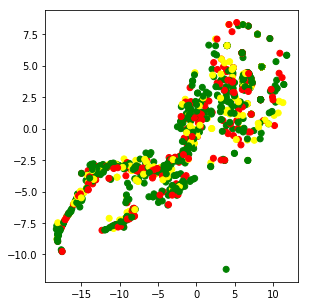

In [188]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_vec.toarray())

# plot the result
vis_x = tsne_results[:, 0]
vis_y = tsne_results[:, 1]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(vis_x, vis_y, c=colors)

In [209]:
for n_neighbors in range(3, 9):
    for weights in ['uniform', 'distance']:
        print(f'N: {n_neighbors} ({weights})')
        affinity_pred = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        scores = cross_validate(affinity_pred, X_vec, y_train_aff.map(score_to_label), scoring=['precision_macro', 'recall_macro', 'f1_macro'], cv=5, return_train_score=True)
        report(scores)
        y_predicted_cv = cross_val_predict(affinity_pred, X_vec, y_train_aff.map(score_to_label), cv=5)
        print(metrics.classification_report(y_train_aff.map(score_to_label), y_predicted_cv))

N: 3 (uniform)
On test  avg precision: 0.32 ± 0.04 avg recall: 0.36 ± 0.03 avg f1: 0.30 ± 0.02
On train  avg precision: 0.61 ± 0.02 avg recall: 0.48 ± 0.01 avg f1: 0.44 ± 0.01
             precision    recall  f1-score   support

   negative       0.29      0.67      0.40       262
    neutral       0.07      0.01      0.02       201
   positive       0.60      0.39      0.47       532

avg / total       0.41      0.39      0.36       995

N: 3 (distance)
On test  avg precision: 0.33 ± 0.04 avg recall: 0.35 ± 0.02 avg f1: 0.31 ± 0.03
On train  avg precision: 0.82 ± 0.00 avg recall: 0.71 ± 0.01 avg f1: 0.69 ± 0.01
             precision    recall  f1-score   support

   negative       0.29      0.62      0.40       262
    neutral       0.12      0.04      0.06       201
   positive       0.57      0.40      0.47       532

avg / total       0.41      0.39      0.37       995

N: 4 (uniform)
On test  avg precision: 0.34 ± 0.03 avg recall: 0.33 ± 0.02 avg f1: 0.30 ± 0.02
On train  avg pr

Doesn't seem to be imrpove over LogReg, consistently worse performance, which kinda might indicate initial BoW model is not actually representing trends in input data / we are missing quite a lot of chars / each relations is a unique snowflake and uses all the different words every time.

Okay, so personal best is LogReg, BoW on stems for words in paragraphs, in which both of characters were mentioned. Let's run this on test set for 'best' kNN (just seemed to be good enough + performance on 'neutral' is not that bad).

In [233]:
kNN = KNeighborsClassifier(n_neighbors=6)
kNN.fit(X_train_vect, y_train_aff.map(score_to_label))
y_predicted = kNN.predict(X_test_vect)
print(metrics.classification_report(y_test_aff.map(score_to_label), y_predicted))

             precision    recall  f1-score   support

   negative       0.30      0.63      0.40       141
    neutral       0.33      0.05      0.09       115
   positive       0.50      0.37      0.43       235

avg / total       0.40      0.37      0.34       491



In [232]:
BoW_LogReg = LogisticRegression()
BoW_LogReg.fit(X_train_vect, y_train_aff.map(score_to_label))
y_predicted = BoW_LogReg.predict(X_test_vect)
print(metrics.classification_report(y_test_aff.map(score_to_label), y_predicted))

             precision    recall  f1-score   support

   negative       0.28      0.11      0.15       141
    neutral       0.33      0.13      0.19       115
   positive       0.49      0.81      0.61       235

avg / total       0.39      0.45      0.38       491



VS Baselines:  
```avg / total       0.46      0.26      0.20      1469```

Well, seems that test performance is 0.05-0.1 worse that CV one. But they are better than baseline's performance.

That's all folks